This document's link: https://colab.research.google.com/drive/1e8AYGMaIfywB3hau8hOvniIvn4JOvAcj

# K-winners-take-all in Deep Learning

The common way to achieve sparse representation in machine learning is done by constraining the sparsness of layers activations $\pmb{a}$ by adding the term $\lambda*S(\pmb{a})$ to the cost function, where $S(\pmb{a})$ measures the sparseness of the representation and $\lambda$ is a constant factor that weights how sparse the representation should be relative to the reconstruction error. We won't use this approach in the current research since we want our representation to be not only sparse but binary as well. Instead, we'll use _k-winners-take-all_ activation function (kWTA), described in the previous section ([link](https://colab.research.google.com/drive/1GEoQnlalGtxDLSzkmmUSo5ulZg2RbtVe)), to train deep neural networks.

Please implement the forward pass of kWTA activation function in pytorch. For the backward pass, assume that nothing happened.

In [0]:
# install pytorch and torchvision
!pip install torch==1.0.0 torchvision==0.2.1
!pip install pillow==4.1.1  # colab pillow issues
# please restart the runtime afterwards

    100% |████████████████████████████████| 2.0MB 14.1MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


    100% |████████████████████████████████| 5.7MB 7.7MB/s 
  Found existing installation: Pillow 5.4.1
    Uninstalling Pillow-5.4.1:
      Successfully uninstalled Pillow-5.4.1


In [0]:
import torch
import math


class KWinnersTakeAllFunction(torch.autograd.Function):

    @staticmethod
    def forward(ctx, tensor, sparsity: float):
        """
        :param tensor: (B, N) input tensor
        :param sparsity: kWTA sparsity (a constant)
        :return: binary SDR of the input tensor
        """
        # your code goes here
        return tensor

    @staticmethod
    def backward(ctx, grad_output):
        """ 
        Pretend that nothing happened.
        Pass the gradient as if we didn't apply kWTA.
        None goes for sparsity, which is constant.
        """
        return grad_output, None


class KWinnersTakeAll(torch.nn.Module):

    def __init__(self, sparsity=0.05):
        """
        :param sparsity: how many bits leave active
        """
        super().__init__()
        assert 0. <= sparsity <= 1., "Sparsity should lie in (0, 1) interval"
        self.sparsity = sparsity

    def forward(self, x):
        x = KWinnersTakeAllFunction.apply(x, self.sparsity)
        return x

    def extra_repr(self):
        return f'sparsity={self.sparsity}'


In [0]:
"""
Sketch to initialize a trainer with MLP.
You can run and skip this section.
"""

from collections import namedtuple, defaultdict

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data
from torchvision import transforms, datasets

torch.random.manual_seed(26)
np.random.seed(26)

DATA_DIR = 'data'
BATCH_SIZE = 256

DatasetInfo = namedtuple("DatsetInfo", ('class_', 'image_size', 'mean', 'std'))

DATASET_INFO = {
    "MNIST": DatasetInfo(class_=datasets.MNIST, image_size=28, mean=[0.1307], std=[0.1932]),
    "CIFAR10": DatasetInfo(class_=datasets.CIFAR10, image_size=32, mean=[0.5, 0.5, 0.5], std=[0.25, 0.25, 0.25]),
}


def get_data_loader(dataset_str: str, train=True, normalize=True, shuffle=True):
    dataset_info = DATASET_INFO[dataset_str]
    transform = [transforms.ToTensor()]
    if normalize:
        transform.append(transforms.Normalize(mean=dataset_info.mean, std=dataset_info.std))
    dataset = dataset_info.class_(DATA_DIR, train=train, download=True, transform=transforms.Compose(transform))
    loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=shuffle, num_workers=0)
    return loader


class MLP(nn.Module):

    def __init__(self, *fc_sizes: int):
        """
        :param fc_sizes: fully-connected layer sizes
        """
        super().__init__()
        fc_sizes = list(fc_sizes)
        n_classes = fc_sizes.pop()
        classifier = []
        for in_features, out_features in zip(fc_sizes[:-1], fc_sizes[1:]):
            linear = nn.Linear(in_features=in_features, out_features=out_features)
            classifier.append(linear)
            classifier.append(nn.ReLU(inplace=True))
        classifier.append(nn.Linear(in_features=fc_sizes[-1], out_features=n_classes))
        self.classifier = nn.Sequential(*classifier)

    def forward(self, x):
        x = x.flatten(start_dim=1)
        x = self.classifier(x)
        return x

    
def full_forward_pass(model: nn.Module, loader: torch.utils.data.DataLoader):
    use_cuda = torch.cuda.is_available()
    outputs_full = []
    labels_full = []
    mode = model.training
    model.eval()
    with torch.no_grad():
        for inputs, labels in iter(loader):
            if use_cuda:
                inputs = inputs.cuda()
            outputs = model(inputs)
            outputs_full.append(outputs.cpu())
            labels_full.append(labels)
            if len(outputs_full) * BATCH_SIZE > 10000:
                break
    model.train(mode)
    outputs_full = torch.cat(outputs_full, dim=0)
    labels_full = torch.cat(labels_full, dim=0)
    return outputs_full, labels_full


class Trainer:

    def __init__(self, model: nn.Module, dataset_str: str, criterion=nn.CrossEntropyLoss()):
        if torch.cuda.is_available():
            model = model.cuda()
        self.model = model
        self.train_loader = get_data_loader(dataset_str, train=True)
        self.test_loader = get_data_loader(dataset_str, train=False)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        self.criterion = criterion

    def save(self, outputs_train, labels_train):
        pass

    def calc_accuracy(self, outputs, labels_true) -> float:
        labels_predicted = outputs.argmax(dim=1)
        accuracy = (labels_true == labels_predicted).type(torch.float32).mean()
        return accuracy.item()

    def train(self, n_epochs=10):
        accuracy_train = []
        accuracy_test = []
        loss_train = []
        use_cuda = torch.cuda.is_available()
        print(f"Training {self.model}")
        for epoch in range(1, n_epochs + 1):
            for batch_id, (images, labels) in enumerate(iter(self.train_loader)):
                if use_cuda:
                    images = images.cuda()
                    labels = labels.cuda()
                self.optimizer.zero_grad()
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step(closure=None)
            outputs_train, labels_train = full_forward_pass(self.model, self.train_loader)
            outputs_test, labels_test = full_forward_pass(self.model, self.test_loader)
            self.save(outputs_train, labels_train)
            loss_train.append(self.criterion(outputs_train, labels_train).item())
            accuracy_train.append(self.calc_accuracy(outputs_train, labels_train))
            accuracy_test.append(self.calc_accuracy(outputs_test, labels_test))
            print(f"Epoch {epoch} / {n_epochs}: Accuracy train={accuracy_train[-1]:.3f}, test={accuracy_test[-1]:.3f}; "
                  f"Loss={loss_train[-1]:.3f}")

        plt.subplot(121)
        plt.plot(range(n_epochs), accuracy_train, label='train', marker='o')
        plt.plot(range(n_epochs), accuracy_test, label='test', marker='o')
        plt.legend()
        plt.title("Accuracy")
        plt.xlabel("Epoch")
        plt.subplot(122)
        plt.plot(range(n_epochs), loss_train, marker='o')
        plt.title("Train loss")
        plt.xlabel("Epoch")
        plt.show()


Processing...
Done!
Training MLP(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)
Epoch 1 / 10: Accuracy train=0.952, test=0.951; Loss=0.164
Epoch 2 / 10: Accuracy train=0.966, test=0.963; Loss=0.113
Epoch 3 / 10: Accuracy train=0.978, test=0.970; Loss=0.075
Epoch 4 / 10: Accuracy train=0.984, test=0.975; Loss=0.056
Epoch 5 / 10: Accuracy train=0.987, test=0.976; Loss=0.045
Epoch 6 / 10: Accuracy train=0.987, test=0.975; Loss=0.043
Epoch 7 / 10: Accuracy train=0.992, test=0.978; Loss=0.030
Epoch 8 / 10: Accuracy train=0.993, test=0.978; Loss=0.025
Epoch 9 / 10: Accuracy train=0.992, test=0.976; Loss=0.027
Epoch 10 / 10: Accuracy train=0.996, test=0.979; Loss=0.017


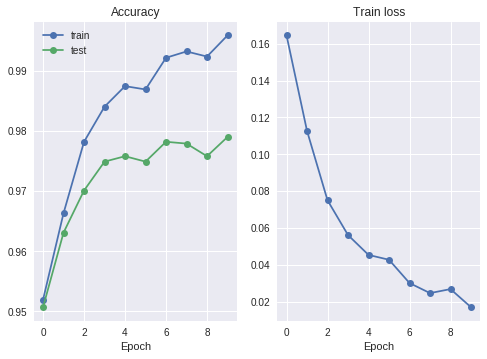

In [0]:
# train a regular MLP on MNIST
Trainer(model=MLP(784, 128, 10), dataset_str="MNIST").train(n_epochs=10)

## SDR embedding vector


Now we add kWTA on top of the last layer to get sparse binary distributed representation. Let's call it SDR embedding vector. We'll train such an embedder with TripletLoss and cosine metric (L1 and L2 also work to less extent).

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt


class TripletLoss(nn.Module):

    def __init__(self, margin=0.5):
        """
        :param margin: TripletLoss margin
        """
        super().__init__()
        self.margin = margin

    def extra_repr(self):
        return f'margin={self.margin}'

    @staticmethod
    def pairs_to_sample(labels):
        """
        Probability of two random samples belonging to the same class
          is 1/n_classes.
        On average, each sample in a batch produces
          1/n_classes * (1 - 1/n_classes) ~ 1/n_classes triplets.
        :param labels: batch of labels
        :return: how many random permutations to sample to get the desired number of triplets
        """
        batch_size = len(labels)
        n_unique = len(labels.unique(sorted=False))
        random_pairs_shape = (n_unique * batch_size,)
        return random_pairs_shape

    def forward(self, outputs, labels):
        """
        :param outputs: (B, D) embeddings tensor
        :param labels: (B,) true labels
        :return: triplet loss
        """
        n_samples = len(outputs)
        pairs_to_sample = self.pairs_to_sample(labels)
        anchor = torch.randint(low=0, high=n_samples, size=pairs_to_sample, device=outputs.device)
        same = torch.randint(low=0, high=n_samples, size=pairs_to_sample, device=outputs.device)
        other = torch.randint(low=0, high=n_samples, size=pairs_to_sample, device=outputs.device)

        triplets = (labels[anchor] == labels[same]) & (labels[anchor] != labels[other])
        anchor = anchor[triplets]
        same = same[triplets]
        other = other[triplets]

        dist_same = 1 - F.cosine_similarity(outputs[anchor], outputs[same], dim=1)
        dist_other = 1 - F.cosine_similarity(outputs[anchor], outputs[other], dim=1)
        loss = dist_same - dist_other + self.margin
        loss = torch.relu(loss).mean()

        return loss


class AccuracyEmbedding:
    """
    Calculates the accuracy for embedding vectors.
    It finds the closest centroid for each sample.
    """

    def __init__(self):
        self.centroids = []

    def distances(self, outputs_test):
        """
        :param outputs_test: (B, D) embeddings tensor
        :return: (B, n_classes) distance matrix to each centroid
        """
        assert len(self.centroids) > 0, "Save train embeddings first"
        centroids = torch.as_tensor(self.centroids, device=outputs_test.device)
        centroids = centroids.unsqueeze(dim=0)  # (1, n_classes, D)
        outputs_test = outputs_test.unsqueeze(dim=1)  # (B, 1, D)
        distances = 1 - F.cosine_similarity(outputs_test, centroids, dim=2)
        return distances

    def save(self, outputs_train, labels_train):
        outputs_train = outputs_train.detach()
        self.centroids = []
        for label in labels_train.unique(sorted=True):
            self.centroids.append(outputs_train[labels_train == label].mean(dim=0))
        self.centroids = torch.stack(self.centroids, dim=0).cpu()

    def predict(self, outputs_test):
        labels_predicted = self.distances(outputs_test).argmin(dim=1)
        return labels_predicted
    
    def plot(self):
        plt.imshow(self.centroids, aspect='auto')
        plt.show()


class TrainerEmbedder(Trainer):

    def __init__(self, model: nn.Module, dataset_str: str, criterion=TripletLoss()):
        super().__init__(model=model, dataset_str=dataset_str, criterion=criterion)
        self.accuracy_measure = AccuracyEmbedding()

    def save(self, outputs_train, labels_train):
        self.accuracy_measure.save(outputs_train, labels_train)

    def calc_accuracy(self, outputs, labels_true) -> float:
        labels_predicted = self.accuracy_measure.predict(outputs)
        accuracy = (labels_true == labels_predicted).type(torch.float32).mean()
        return accuracy.item()


In [0]:
# now add kWTA on top of the last layer to get SDR embeddings

kwta = KWinnersTakeAll(sparsity=0.05)
model = nn.Sequential(MLP(784, 256, 128), kwta)

TrainerEmbedder(model=model, dataset_str="MNIST", criterion=TripletLoss()).train(n_epochs=10)

## Soft kWTA

Although vanilla kWTA does achieve some accuracy on MNIST, it fails on other datasets, because we don't know how to implement its backward pass correctly. Since the gradient of the sign function is zero almost everywhere, we must resort to alternatives of the sign function. How to make it soft? What activation function does resemble sign at infinities?

In [0]:
class KWinnersTakeAllSoft(KWinnersTakeAll):
    """
    Soft implementation of kWTA.
    """

    def forward(self, x):
        if self.training:
            # your code goes here
            pass
        else:
            # at inference we want the output to be strictly binary
            x = super().forward(x)
        return x

In [0]:
# let's try our soft-kwta

kwta = KWinnersTakeAllSoft(sparsity=0.05)
model = nn.Sequential(MLP(784, 256, 128), kwta)

trainer = TrainerEmbedder(model=model, dataset_str="MNIST", criterion=TripletLoss())
trainer.train(n_epochs=10)

One more nice thing about binary SDR embeddings is that they be easily visualized. Our embeddings should cluster in separable groups in the embedding space and we can easily check that by looking at their averaged activations (per class). Such a plot brings a lot of information about model accuracy, which will be hardly the case if you use dense floating point values.

In [0]:
trainer.accuracy_measure.plot()  # show embeddings mean

Training MLP(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=256, out_features=128, bias=True)
  )
)
Epoch 1 / 10: Accuracy train=0.942, test=0.939; Loss=0.031
Epoch 2 / 10: Accuracy train=0.959, test=0.957; Loss=0.021
Epoch 3 / 10: Accuracy train=0.965, test=0.960; Loss=0.017
Epoch 4 / 10: Accuracy train=0.971, test=0.964; Loss=0.014
Epoch 5 / 10: Accuracy train=0.975, test=0.968; Loss=0.012
Epoch 6 / 10: Accuracy train=0.978, test=0.969; Loss=0.010
Epoch 7 / 10: Accuracy train=0.978, test=0.971; Loss=0.010
Epoch 8 / 10: Accuracy train=0.979, test=0.973; Loss=0.009
Epoch 9 / 10: Accuracy train=0.981, test=0.968; Loss=0.008
Epoch 10 / 10: Accuracy train=0.983, test=0.973; Loss=0.007


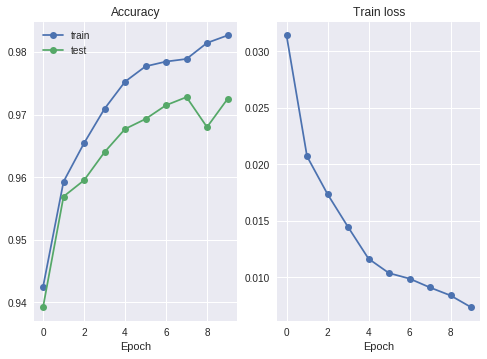

In [0]:
# you can compare soft-kwta results with dense real-valued embeddings
# and make sure that the accuracy doesn't suffer much if we apply binarization
TrainerEmbedder(model=MLP(784, 256, 128), dataset_str="MNIST", criterion=TripletLoss()).train(n_epochs=10)

More examples of soft kWTA, added on top of VGG, DenseNet, ResNet, MobileNet on CIFAR10 and Caltech256 datasets, you can find at http://ec2-18-234-90-227.compute-1.amazonaws.com:8097. Give your browser a few minutes to parse the json data.


## Conclusion

Now you know a simple way to get sparse binary distributed representation of your data in deep learning framework. The amazing part of it is that, once you get SDR, you forget about deep learning and take the ideas from neuroscience to move forward. And you're ready to explore it.

For example, you could try associating two subsequent frames in a video, using the method, described above, to obtain SDR of an image and then associate it with the SDR of the next frame, using the knowldege you obtained in the previous tutorial about Willshaw's associative memory. One of the major problems that I don't know how to solve is how to get SDR in unsupervised local fashion (no backprop). Maybe, you can get it with Willshaw's associative rules as well by exploring the parts of the scene (image) with saccades (attention jumps) and then associating these parts in one SDR of the whole image.

Another thrilling example are math operations on binary SDRs: their union, intersection, and difference might create new interesting SDRs. It's like GAN but... binary. For example, an image of the dog `0010001000011` on the grass `0000101001010` can be represented as the union of their representations - `0010101001011`. At the same time, a dog's SDR might consist of its underlying representations (fur, feet, tail, etc.).